In [1]:
"""
Chained evaluation of the models.
"""
import argparse
import datetime
import h5py
import json
import os
import time
from pathlib import Path

import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
from transformers import AutoTokenizer, CLIPTextModel, BertTokenizer, BertModel

import util.misc as misc
from engine_node2node import get_text_embeddings
from util.datasets import build_shape_surface_occupancy_dataset


def get_args_parser():
    parser = argparse.ArgumentParser("Performing Chained Eval", add_help=False)

    # Model parameters
    parser.add_argument(
        "--batch_size",
        default=32,
        type=int,
        help="Batch size per GPU (effective batch size is batch_size * accum_iter * # gpus",
    )
    parser.add_argument(
        "--text_model_name",
        type=str,
        help="Text model name to use",
    )
    parser.add_argument(
        "--ae",
        type=str,
        metavar="MODEL",
        help="Name of autoencoder",
    )
    parser.add_argument(
        "--ae-latent-dim",
        type=int,
        default=512*8,
        help="AE latent dimension",
    )
    parser.add_argument(
        "--ae_pth",
        required=True,
        help="Autoencoder checkpoint"
    )
    parser.add_argument(
        "--point_cloud_size",
        default=2048,
        type=int,
        help="input size"
    )
    parser.add_argument(
        "--fetch_keys",
        action="store_true",
        default=False,
    )
    parser.add_argument(
        "--use_clip",
        action="store_true",
        default=False,
    )
    parser.add_argument(
        "--use_embeds",
        action="store_true",
        default=False,
    )
    parser.add_argument(
        "--intensity_loss",
        action="store_true",
        default=False,
        help="Contrastive edit intensity loss using ground-truth labels.",
    )

    # Dataset parameters
    parser.add_argument(
        "--dataset",
        type=str,
        choices=["graphedits", "graphedits_chained"],
        help="dataset name",
    )
    parser.add_argument(
        "--data_path",
        type=str,
        help="dataset path",
    )
    parser.add_argument(
        "--data_type",
        type=str,
        help="dataset type",
    )
    parser.add_argument(
        "--max_edge_level",
        default=None,
        type=int,
        help="maximum edge level to use",
    )
    parser.add_argument(
        "--chain_length",
        default=None,
        type=int,
        help="length of chains to load",
    )
    parser.add_argument(
        "--device", default="cuda", help="device to use for training / testing"
    )
    parser.add_argument("--seed", default=0, type=int)
    parser.add_argument("--num_workers", default=60, type=int)
    parser.add_argument(
        "--pin_mem",
        action="store_true",
        help="Pin CPU memory in DataLoader for more efficient (sometimes) transfer to GPU.",
    )
    parser.add_argument(
        "--alt_ae_embeds",
        type=str,
        default=None,
        help="Alternative autoencoder embeddings to use",
    )
    parser.add_argument(
        "--ft_bert",
        action="store_true",
        default=False,
        help="Also fine-tune the BERT model",
    )
    parser.add_argument(
        "--model",
        type=str,
        metavar="MODEL",
    )
    parser.add_argument(
        "--resume",
        default="",
        help="Resume from checkpoint"
    )
    parser.add_argument(
        "--resume_full_weights",
        action="store_true",
        default=False,
        help="Resume the full model weights with the EDM wrapper",
    )

    return parser

In [2]:
import models.mlp_mapper as mlp_mapper

# Set dummy arg string to debug the parser
call_string = """--ae_pth /ibex/user/slimhy/Shape2VecSet/output/pc_ae/best_model.pt \
    --ae-latent-dim 256 \
    --text_model_name bert-base-uncased \
    --dataset graphedits_chained \
    --data_path /ibex/user/slimhy/ShapeWalk/ \
    --data_type release_chained \
    --batch_size 32 \
    --chain_length 10 \
    --num_workers 8 \
    --model mlp_mapper_bert_bneck_512_pcae \
    --resume /ibex/user/slimhy/Shape2VecSet/output/graph_edit/dm/mlp_mapper_bert_bneck_512_pcae__fine_chained/checkpoint-59.pth \
    --resume_full_weights \
    --device cuda \
    --fetch_keys \
    --use_embeds \
    --alt_ae_embeds pc_ae \
    --seed 0"""

# Parse the arguments
args = get_args_parser()
args = args.parse_args(call_string.split())
args.use_clip = "clip" in args.text_model_name
device = torch.device(args.device)

model = mlp_mapper.__dict__[args.model](use_linear_proj=not args.use_clip)
model.to(device)

# Load the checkpoint
if args.resume:
    print("Loading checkpoint [%s]..." % args.resume)
    checkpoint = torch.load(args.resume, map_location="cpu")
    model.load_state_dict(checkpoint["model"])
    print("Done.")

Loading checkpoint [/ibex/user/slimhy/Shape2VecSet/output/graph_edit/dm/mlp_mapper_bert_bneck_512_pcae__fine_chained/checkpoint-59.pth]...
Done.


In [3]:
dataset_train = build_shape_surface_occupancy_dataset("train", args=args)
dataset_val = build_shape_surface_occupancy_dataset("val", args=args)

In [4]:
from torch.utils.data import Dataset, DataLoader, Sampler


class ChainSampler(Sampler):
    def __init__(self, dataset, batch_size, chain_length):
        self.dataset = dataset
        self.batch_size = batch_size
        self.chain_length = chain_length
        self.num_samples = len(dataset)
        self.n_batches = self.num_samples // (self.batch_size)
        self.n_chains = self.num_samples // self.chain_length

    def __iter__(self):
        t = 0
        for m in range(self.n_chains):
            for k in range(self.chain_length):
                for j in range(self.batch_size):
                    yield m*(self.chain_length*self.batch_size)+k+j*self.chain_length
                    t += 1
                    if t == self.num_samples:
                        return

    def __len__(self):
        return self.num_samples


chain_sampler = ChainSampler(dataset_val, batch_size=args.batch_size, chain_length=args.chain_length)
dataloader_val = DataLoader(dataset=dataset_val, batch_size=args.batch_size, sampler=chain_sampler)
dataloader_train = DataLoader(dataset=dataset_train, batch_size=args.batch_size, sampler=chain_sampler)

In [5]:
# --------------------

# Fix the seed for reproducibility
seed = args.seed + misc.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)

cudnn.benchmark = True

args.fetch_keys = True
#dataset_train = build_shape_surface_occupancy_dataset("train", args=args)
#dataset_val = build_shape_surface_occupancy_dataset("val", args=args)

# Create data loaders
data_loader_val = torch.utils.data.DataLoader(
    dataset_val,
    batch_size=args.batch_size,
    shuffle=True,
    num_workers=args.num_workers,
    pin_memory=True,
    drop_last=True,
)
# --------------------

/home/slimhy/conda/envs/shape2vecset/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
import json
import torch
import numpy as np
import os.path as osp
import pprint
import warnings

from argparse import ArgumentParser
from models.mlp import MLP
from models.point_net import PointNet
from models.pointcloud_autoencoder import PointcloudAutoencoder


def describe_pc_ae(args):
    # Make an AE.
    if args.encoder_net == "pointnet":
        ae_encoder = PointNet(init_feat_dim=3, conv_dims=args.encoder_conv_layers)
        encoder_latent_dim = args.encoder_conv_layers[-1]
    else:
        raise NotImplementedError()

    if args.decoder_net == "mlp":
        ae_decoder = MLP(
            in_feat_dims=encoder_latent_dim,
            out_channels=args.decoder_fc_neurons + [args.n_pc_points * 3],
            b_norm=False,
        )

    model = PointcloudAutoencoder(ae_encoder, ae_decoder)
    return model


def load_state_dicts(checkpoint_file, map_location=None, **kwargs):
    """ Load torch items from saved state_dictionaries"""
    if map_location is None:
        checkpoint = torch.load(checkpoint_file)
    else:
        checkpoint = torch.load(checkpoint_file, map_location=map_location)

    for key, value in kwargs.items():
        value.load_state_dict(checkpoint[key])

    epoch = checkpoint.get('epoch')
    if epoch:
        return epoch


def read_saved_args(config_file, override_or_add_args=None, verbose=False):
    """
    :param config_file: json file containing arguments
    :param override_args: dict e.g., {'gpu': '0'} will set the resulting arg.gpu to be 0
    :param verbose:
    :return:
    """
    parser = ArgumentParser()
    args = parser.parse_args([])
    with open(config_file, "r") as f_in:
        args.__dict__ = json.load(f_in)

    if override_or_add_args is not None:
        for key, val in override_or_add_args.items():
            args.__setattr__(key, val)

    if verbose:
        args_string = pprint.pformat(vars(args))
        print(args_string)

    return args


def load_pretrained_pc_ae(model_file):
    config_file = osp.join(osp.dirname(model_file), "config.json.txt")
    pc_ae_args = read_saved_args(config_file)
    pc_ae = describe_pc_ae(pc_ae_args)

    if osp.join(pc_ae_args.log_dir, "best_model.pt") != osp.abspath(model_file):
        warnings.warn(
            "The saved best_model.pt in the corresponding log_dir is not equal to the one requested."
        )

    best_epoch = load_state_dicts(model_file, model=pc_ae)
    print(f"Pretrained PC-AE is loaded at epoch {best_epoch}.")
    return pc_ae, pc_ae_args


# Instantiate autoencoder
print("Loading autoencoder [%s]..." % args.ae_pth)
pc_ae, pc_ae_args = load_pretrained_pc_ae(args.ae_pth)
pc_ae = pc_ae.to(device)
pc_ae = pc_ae.eval()
print("Done.")

Jitting Chamfer 3D
Loaded JIT 3D CUDA chamfer distance
Loading autoencoder [/ibex/user/slimhy/Shape2VecSet/output/pc_ae/best_model.pt]...
Pretrained PC-AE is loaded at epoch 186.
Done.


/tmp/ipykernel_64405/3058541129.py:77: UserWarning: The saved best_model.pt in the corresponding log_dir is not equal to the one requested.
  warnings.warn(


In [7]:
from plot_pc import plot_pointclouds

def apply_edit(net, x_a, embed_ab):
    # Reshape from (B, D, K) to (B, M)
    x_a = x_a.flatten(1)
    embed_ab = embed_ab.flatten(1)

    # Concatenate the latent vector with the embedding
    edit_vec = net(x_a, embed_ab)

    # Add the edit vector to the latent vector
    return x_a + edit_vec

def apply_iterated_edits(model, embeds_a, embeds_b, embeds_text):
    # Move all the garbage to CUDA
    embeds_a = embeds_a.cuda()
    embeds_b = embeds_b.cuda()
    embeds_text = embeds_text.cuda()

    x_b_edited = apply_edit(model, embeds_a, embeds_text)
    x_b = embeds_b
    x_a = embeds_a

    # Decode the batch
    b_size = x_b.shape[0]

    with torch.inference_mode():
        orig = pc_ae.decoder(x_a).reshape([b_size, 4096, 3])
        rec = pc_ae.decoder(x_b_edited).reshape([b_size, 4096, 3])
        rec_gt = pc_ae.decoder(x_b).reshape([b_size, 4096, 3])

    return (orig, rec, rec_gt), (x_a, x_b_edited, x_b)

def apply_iterated_edits__SAFE(model, embeds_a, embeds_text):
    # Move all the garbage to CUDA
    embeds_a = embeds_a.cuda()
    embeds_text = embeds_text.cuda()

    x_b_edited = apply_edit(model, embeds_a, embeds_text)
    x_a = embeds_a

    # Decode the batch
    b_size = x_a.shape[0]

    with torch.inference_mode():
        orig = pc_ae.decoder(x_a).reshape([b_size, 4096, 3])
        rec = pc_ae.decoder(x_b_edited).reshape([b_size, 4096, 3])

    return (orig, rec), (x_a, x_b_edited)

In [8]:
with torch.no_grad():
    cum_metrics = {}
    total_iter = 0
    for _, edit_keys, node_a, node_b, text_embeds in data_loader_val:
        if len(cum_metrics) == 0:
            prev_tuple = node_a, node_b, text_embeds
        
        # Apply the edits
        (orig, rec, rec_gt), (x_a, x_b_edited, x_b) = apply_iterated_edits(model, *prev_tuple)

        print(x_b.shape)

        # Compute average pairwise L2 distance in feature space
        l2_dist = torch.norm(x_b_edited - x_b, dim=-1)
        cum_metrics["l2_dist"] = cum_metrics.get("l2_dist", 0) + l2_dist.sum().item()
        total_iter += l2_dist.shape[0]

        prev_tuple = x_a, x_b_edited, text_embeds
        break

/home/slimhy/conda/envs/shape2vecset/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([32, 256])


In [9]:
node_a.shape

torch.Size([32, 256])

In [9]:
import json

json_f = "/ibex/user/slimhy/ShapeWalk/release_chained/release_chained_val.json"
json_d = json.load(open(json_f))

def get_prompt(edit_key):
    return json_d[edit_key]["prompt"]

In [169]:
with torch.no_grad():
    cum_metrics = {}
    total_iter = 0
    for _, edit_keys, node_a, _, text_embeds in data_loader_val:
        if len(cum_metrics) == 0:
            prev_tuple = node_a, text_embeds
        
        # Apply the edits
        (orig, rec), (x_a, x_b_edited) = apply_iterated_edits__SAFE(model, *prev_tuple)

        # Compute average pairwise L2 distance in feature space
        #cum_metrics["l2_dist"] = cum_metrics.get("l2_dist", 0) + l2_dist.sum().item()
        #total_iter += l2_dist.shape[0]

        prev_tuple = x_a, x_b_edited, text_embeds
        total_iter += 1
        if total_iter == 12:
            break

/home/slimhy/conda/envs/shape2vecset/lib/python3.10/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [170]:
from plot_pc import plot_pointclouds

n_iter = iter(range(args.batch_size))

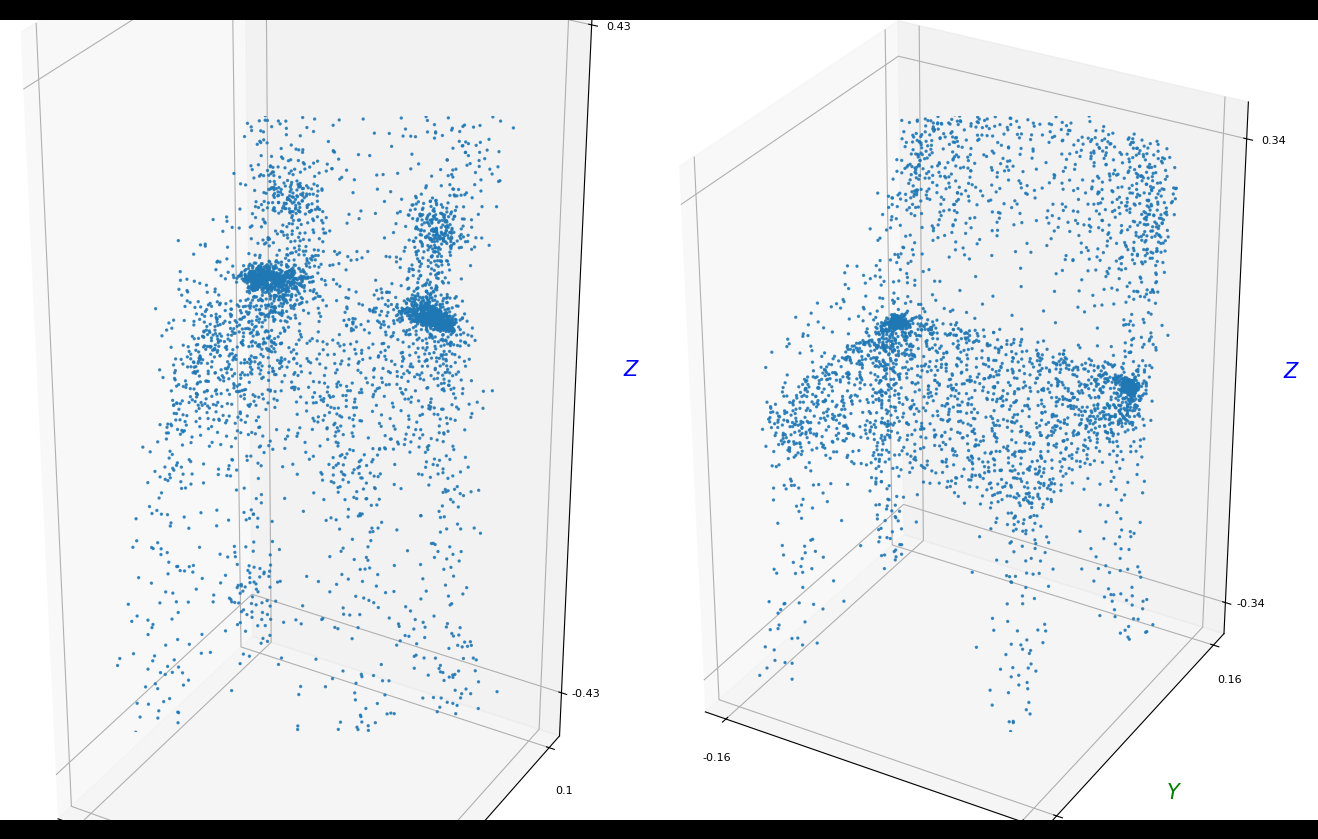

In [219]:
k = next(n_iter)

orig_cp = orig[k].detach().cpu().numpy()
rec_cp = rec[k].detach().cpu().numpy()
plot_pointclouds([orig_cp, rec_cp])

In [221]:
edit_key = edit_keys[k]
prompt = get_prompt(edit_keys[k])
print(prompt)

Decrease chair height quite a lot.


In [222]:
np.save("output_alt/%s__orig" % edit_key, orig_cp)
np.save("output_alt/%s__erc" % edit_key, rec_cp)

with open("output_alt/%s__prompt.txt" % edit_key, "w") as f:
    f.write(prompt)